# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt                        
%matplotlib inline              

from PIL import Image
from PIL import ImageFile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [3]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1
(1, 4)


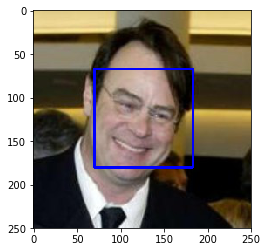

In [4]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))
print(faces.shape)

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [142]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [143]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_result = np.vectorize(face_detector)(human_files_short)
dog_result = np.vectorize(face_detector)(dog_files_short)

In [148]:
human_percentage = human_result.sum()/100 * 100

In [149]:
dog_percentage = dog_result.sum()/100 * 100

In [151]:
print(f'Percent Human: {human_percentage}%')
print(f'Percent Dog: {dog_percentage}%')

Percent Human: 98.0%
Percent Dog: 17.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [43]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [152]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [153]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    img = data_transforms(Image.open(img_path))
    output = VGG16(img[None, :])
    return output.argmax(dim=1)


In [154]:
img = cv2.imread(dog_files[0])

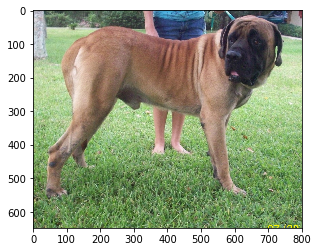

In [155]:
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [157]:
result = VGG16_predict(dog_files[0])

In [158]:
result.item()

243

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [159]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, show_img=False):
    if show_img:
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # display the image, along with bounding box
        plt.imshow(cv_rgb)
        plt.show()
    
    class_index = VGG16_predict(img_path).item()
    dog_range = range(151, 268 + 1) # inclusive range
    return class_index in dog_range

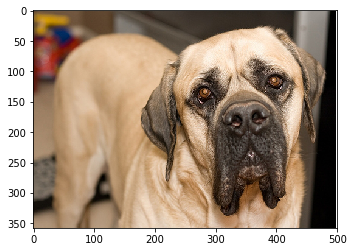

True

In [160]:
dog_detector(dog_files[5], True)

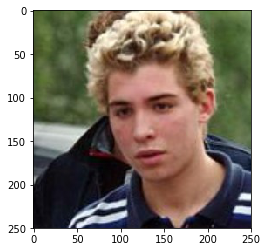

False

In [161]:
dog_detector(human_files[2], True)

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [162]:
dog_predictions = np.array([dog_detector(img) for img in dog_files_short])

In [163]:
dog_accuracy = dog_predictions.sum()/100

In [164]:
print("Dog accuracy: {0:.0f}%".format(dog_accuracy * 100))

100%


In [165]:
human_predictions = np.array([dog_detector(img) for img in human_files_short])

In [166]:
human_accuracy = human_predictions.sum()/100

In [167]:
print("Human accuracy: {0:.0f}%".format(human_accuracy * 100))

1%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [5]:
batch_size = 64
num_workers = 0

base_path = "/data/dog_images"

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(base_path+"/train", transform=train_transform)
valid_dataset = datasets.ImageFolder(base_path+"/valid", transform=test_transforms)
test_dataset = valid_dataset = datasets.ImageFolder(base_path+"/test", transform=test_transforms)

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [4]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(6680, 836, 836)

In [26]:
classes = train_dataset.classes

In [27]:
len(classes)

133

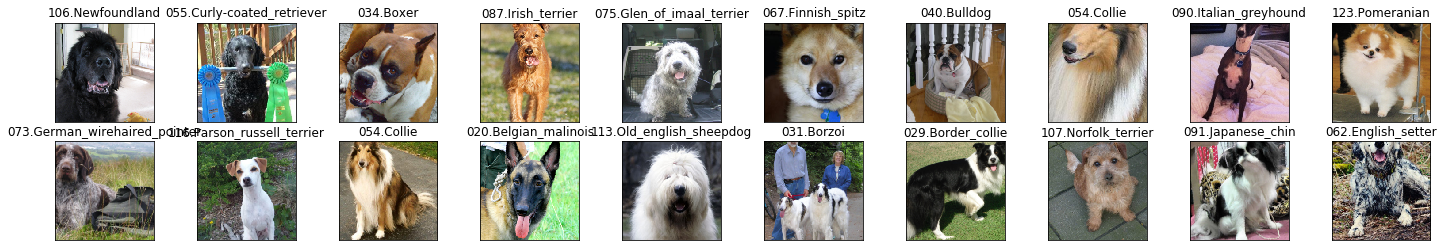

In [7]:
batch = iter(train_loader)
images, target = batch.next()
images = images.numpy()

mean = 0.5
std = 0.5

images = ((images * std) + mean)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[target[idx]])

In [108]:
images.shape, target.shape

((64, 3, 224, 224), torch.Size([64]))

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
For the training dataset, I added additional data augmentations such as RandomHorizontalFlip and RandomRotation of 10 degrees before resizing to 256 and then center cropping the images to 224. After that, I converted the images to tensor form and normalized the images with a mean of 0.5 and a standard deviation of 0.5. The input shape of each image tensor is 3, 224, 224. 

I chose 224 for an image size as it's the default image size for the ResNet model trained on the ImageNet data set. I added a random horizontal flip to add more variation to the training set so that the model could generalize better. A rotation of 10 degrees added more variation to the training set so the model could learn to be rotation invariant.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [168]:
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self, num_classes):
        super(Net, self).__init__()
        #224 x 224 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        # 112 x 112
        
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(56 * 56 * 24, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, num_classes)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 56 * 56 * 24)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
    
        x = self.fc3(x)
        
        return x

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
I went through several iterations of the model. At first, I started with a complex model with many convolution layers and linear layers. That proved difficult to train, and I kept running into out-of-memory cuda errors. I decreased the batch size but still was generating a massive model. I decided to start simple and add more complexity only after the model was trained with enough epochs to start overfitting.

My first model started with three convolutional layers and one max pooling layer. I added 2 fully-connected layers and a dropout of 20%. The first convolutional layer started with a in_channel of three and ended with 24 output channels in the final convolutional layer. This model did not train well and started to overfit early. I then added another max-pooling layer, which brought my input features to 56 * 56 * 24. I was able to train this model for 18 epochs before the validation loss started increasing. The validation loss reached 3.927412 with an accuracy of 0.106459.

The next modification increased the dropout to 50%, but the model trained too slowly, and by epoch 17, it only had 3% accuracy on the validation set. I brought the dropout back to 20% and increased the learning rate from 0.001 to 0.01. The model did not train well with this increased learning rate. 

I set the learning rate back to 0.001 and added a new fully-connected layer called fc3. Each fully-connected layer had a ReLU activation function along with a dropout of 20%. With this new layer, the model was able to train longer for up to 36 epochs before the validation and training loss started to diverge. This model reached a validation loss of 3.882211 and an accuracy of 0.107656. 

For the final experiment, I increased dropout to 30% for the model to train longer before overfitting. This allowed me to train 35 epochs with a validation loss of 3.799896 and an accuracy of 0.119617. This model was able to reach 11% accuracy on the test set.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [110]:
# instantiate the CNN
model_scratch = Net(len(classes))

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [111]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001, weight_decay=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [6]:
def accuracy(output, target):
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    return np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())

In [7]:
def validate(model, validation_loader, criterion, use_cuda):
    valid_loss = 0.0
    valid_accuracy = 0.0
    
#     print("Start Validation")
    model.eval()
    for batch_idx, (data, target) in enumerate(validation_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        ## update the average validation loss
        output = model(data)
        loss = criterion(output, target)
        
        batch_accuracy = accuracy(output, target)

        valid_accuracy += batch_accuracy
        valid_loss += loss.item() * data.size(0)

#     print("Completed Validation")
    valid_loss = valid_loss/len(validation_loader.dataset)
    valid_accuracy = valid_accuracy / len(validation_loader.dataset)
    
    return valid_loss, valid_accuracy

In [10]:
def train(model, training_loader, criterion, optimizer, use_cuda):
#     print("Start training")
    train_loss = 0.0
    train_accuracy = 0.0
    
    model.train()
    for batch_idx, (data, target) in enumerate(training_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        loss.backward()

        optimizer.step()
        
        batch_accuracy = accuracy(output, target)

        train_loss += loss.item() * data.size(0)

        train_accuracy += batch_accuracy
            
    train_loss = train_loss / len(training_loader.dataset)
    train_accuracy = train_accuracy / len(training_loader.dataset)
#     print("Complete training")
    
    return train_loss, train_accuracy

In [11]:
def fit(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        
        train_loss, train_accuracy = train(model, loaders['train'], criterion, optimizer, use_cuda)
        
        valid_loss, valid_accuracy = validate(model, loaders['valid'], criterion, use_cuda)
        
        print('Epoch: {}'.format(epoch))
        # print training/validation statistics 
        print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format( 
            train_loss,
            valid_loss
            ))
        
        print('Training Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            train_accuracy,
            valid_accuracy
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, 
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
        # Call the learning rate adjustment function
        # adjust_learning_rate(epoch, optimizer)
            
    # return trained model
    return model

In [12]:
model_path = 'model_experiment_7.pt'

In [118]:
from workspace_utils import active_session

with active_session():
    # train the model
    model_scratch = fit(100, loaders_scratch, model_scratch, optimizer_scratch, 
                          criterion_scratch, use_cuda, model_path)

Epoch: 1
Training Loss: 4.796238 	Validation Loss: 4.640865
Training Accuracy: 0.014072 	Validation Accuracy: 0.019139
Validation loss decreased (inf --> 4.640865).  Saving model ...
Epoch: 2
Training Loss: 4.611803 	Validation Loss: 4.484011
Training Accuracy: 0.020958 	Validation Accuracy: 0.037081
Validation loss decreased (4.640865 --> 4.484011).  Saving model ...
Epoch: 3
Training Loss: 4.455582 	Validation Loss: 4.488929
Training Accuracy: 0.033234 	Validation Accuracy: 0.022727
Epoch: 4
Training Loss: 4.382851 	Validation Loss: 4.306240
Training Accuracy: 0.038323 	Validation Accuracy: 0.039474
Validation loss decreased (4.484011 --> 4.306240).  Saving model ...
Epoch: 5
Training Loss: 4.316824 	Validation Loss: 4.262050
Training Accuracy: 0.046557 	Validation Accuracy: 0.035885
Validation loss decreased (4.306240 --> 4.262050).  Saving model ...
Epoch: 6
Training Loss: 4.261870 	Validation Loss: 4.232628
Training Accuracy: 0.044461 	Validation Accuracy: 0.055024
Validation loss

KeyboardInterrupt: 

In [81]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(model_path))

In [13]:
model_path

'model_experiment_7.pt'

In [83]:
model_scratch

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=75264, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3)
)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [14]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += accuracy(output, target)
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [86]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.821086


Test Accuracy: 11% (100/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [15]:
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [16]:
## TODO: Specify model architecture 
import torchvision.models as models
# model_transfer = models.resnet18(pretrained=True)
model_transfer = models.resnet50(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 92813657.42it/s]


In [17]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [18]:
for param in model_transfer.parameters():
    param.requires_grad = False

In [38]:
classes = loaders_transfer['train'].dataset.classes

In [39]:
fc = nn.Linear(2048, len(classes))
fc

Linear(in_features=2048, out_features=133, bias=True)

In [40]:
model_transfer.fc = fc

In [41]:
model_transfer.fc

Linear(in_features=2048, out_features=133, bias=True)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
From my experience with creating my own CNN, I decided to start with a simple pretrained model and increase the complexity until reaching a sufficient accuracy. I started with a ResNet model with 18 layers. I froze all the parameters and replaced the final fully-connected layer with a new nn.Linear layer. This model trained for 93 epochs and reached a validation accuracy of 80% with a validation loss of 0.942646.

I moved on to training a larger ResNet model with 50 layers. I replaced the final layer with a new fully-connected layer. This model was able to train much longer for 136 epochs. It reached a validation loss of 0.452324 and an accuracy of 0.885167. It performed well on the test set, achieving an accuracy of 88%. The size of the model was much larger than the 18 layer version and took much longer to train. 

Test Loss: 0.437107
Test Accuracy: 88% (744/836)

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [42]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [43]:
model_path = 'model_transfer_exp_2.pt'

In [44]:
# move tensors to GPU if CUDA is available
if use_cuda:
    model_transfer.cuda()

In [121]:
# train the model
with active_session():
    model_scratch = fit(100, loaders_transfer, model_transfer, optimizer_transfer, 
                      criterion_transfer, use_cuda, model_path)

Epoch: 1
Training Loss: 0.538624 	Validation Loss: 0.502970
Training Accuracy: 0.898204 	Validation Accuracy: 0.880383
Validation loss decreased (inf --> 0.502970).  Saving model ...
Epoch: 2
Training Loss: 0.534446 	Validation Loss: 0.493604
Training Accuracy: 0.894760 	Validation Accuracy: 0.886364
Validation loss decreased (0.502970 --> 0.493604).  Saving model ...
Epoch: 3
Training Loss: 0.529055 	Validation Loss: 0.493175
Training Accuracy: 0.898503 	Validation Accuracy: 0.880383
Validation loss decreased (0.493604 --> 0.493175).  Saving model ...
Epoch: 4
Training Loss: 0.536833 	Validation Loss: 0.485217
Training Accuracy: 0.890719 	Validation Accuracy: 0.880383
Validation loss decreased (0.493175 --> 0.485217).  Saving model ...
Epoch: 5
Training Loss: 0.528340 	Validation Loss: 0.496950
Training Accuracy: 0.895060 	Validation Accuracy: 0.880383
Epoch: 6
Training Loss: 0.526194 	Validation Loss: 0.490791
Training Accuracy: 0.890868 	Validation Accuracy: 0.877990
Epoch: 7
Traini

KeyboardInterrupt: 

In [45]:
# load the model that got the best validation accuracy (uncomment the line below)
# model_transfer.load_state_dict(torch.load(model_path, map_location='cpu'))
model_transfer.load_state_dict(torch.load(model_path))

In [46]:
model_path

'model_transfer_exp_2.pt'

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [47]:
model_transfer.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [48]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.435093


Test Accuracy: 88% (744/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [30]:
import json

with open('cnn_classes.json', 'w', encoding='utf-8') as f:
  json.dump(class_names, f, ensure_ascii=False, indent=4)

In [31]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in classes]

def predict_breed_transfer(img_path):
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    model_transfer.eval()
    img = data_transforms(Image.open(img_path))
    output = model_transfer(img[None, :])
    pred = output.argmax(dim=1)
    return class_names[pred]

In [32]:
predict_breed_transfer('./images/Welsh_springer_spaniel_08203.jpg')

'Welsh springer spaniel'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [132]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path, show_image=False):
    ## handle cases for a human face, dog, and neither
    print("******************************************************")
    print("Welcome...Let's find out if you are a human or a dog.")
    if show_image:
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # display the image, along with bounding box
        plt.imshow(cv_rgb)
        plt.show()
    is_dog = dog_detector(img_path)
    if is_dog:
        print("Looks like you are a dog! Woof Woof")
        print("Now, let's find out your breed.")
        dog_breed = predict_breed_transfer(img_path)
        print(f"You must be a {dog_breed}.")
        return 
    print("hm, you don't seem to be a dog. Let's see if you are a human!")
    is_human = face_detector(img_path)
    if is_human:
        print("Welcome Human!")
        dog_breed = predict_breed_transfer(img_path)
        print("You look like a...")
        print(dog_breed)
        return 
    
    print("You don't seem to be a human or a dog.")
    return -1
    


In [133]:
dog = dog_files_short[0]

In [134]:
human = human_files_short[3]

******************************************************
Welcome...Let's find out if you are a human or a dog.


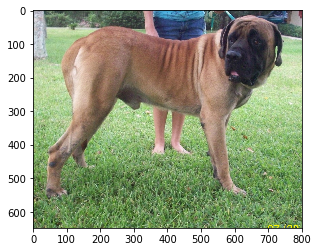

Looks like you are a dog! Woof Woof
Now, let's find out your breed.
You must be a Mastiff.


In [135]:
run_app(dog, True)

******************************************************
Welcome...Let's find out if you are a human or a dog.


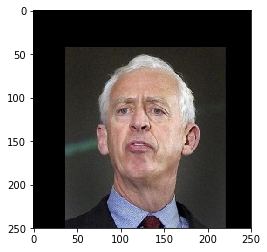

hm, you don't seem to be a dog. Let's see if you are a human!
Welcome Human!
You look like a...
Bull terrier


In [136]:
run_app(human, True)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The output is better than I expected, especially for the dog or human detector. The dog breed pre-trained model could use some improvement to reach a 95% accuracy. To do this, I could improve the training set, add more data augmentations, try adding more fully-connected layers, or train with different learning rates. Another area for improvement is to show the top 5 probabilities if the model is unsure of a breed.

The face detector model could leverage a pre-trained model for face detection, such as Pytorch face detection (MTCNN) and recognition (InceptionResnet). It would also be useful to inspect the CNN to see how the layers are activated to understand which layers are being activated for a particular human face when the model is trying to predict their dog breed.

******************************************************
Welcome...Let's find out if you are a human or a dog.


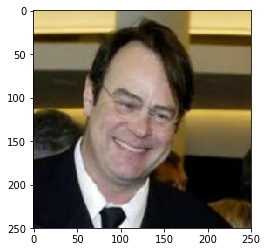

hm, you don't seem to be a dog. Let's see if you are a human!
Welcome Human!
You look like a...
Dachshund
******************************************************
Welcome...Let's find out if you are a human or a dog.


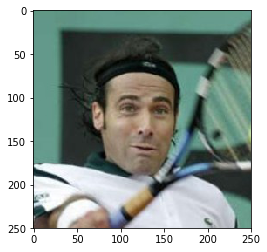

hm, you don't seem to be a dog. Let's see if you are a human!
Welcome Human!
You look like a...
Dachshund
******************************************************
Welcome...Let's find out if you are a human or a dog.


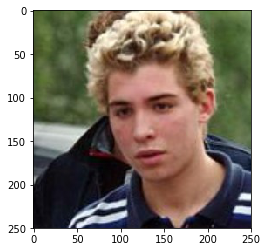

hm, you don't seem to be a dog. Let's see if you are a human!
Welcome Human!
You look like a...
American water spaniel
******************************************************
Welcome...Let's find out if you are a human or a dog.


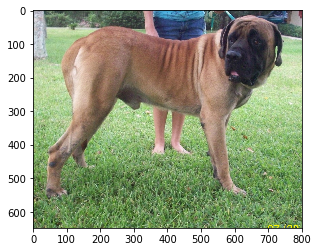

Looks like you are a dog! Woof Woof
Now, let's find out your breed.
You must be a Mastiff.
******************************************************
Welcome...Let's find out if you are a human or a dog.


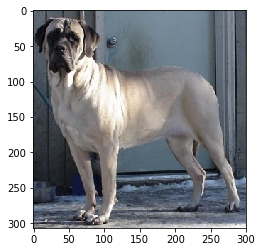

Looks like you are a dog! Woof Woof
Now, let's find out your breed.
You must be a Mastiff.
******************************************************
Welcome...Let's find out if you are a human or a dog.


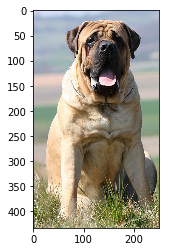

Looks like you are a dog! Woof Woof
Now, let's find out your breed.
You must be a Bullmastiff.


In [137]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file, True)